In [330]:
from collections import Counter
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime

In [438]:
dfla=pd.read_csv("https://github.com/MachineLearningUniandes/MANTRA/raw/master/data/lightcurves/transient_labels.csv")

In [767]:
df=pd.read_csv("https://github.com/MachineLearningUniandes/MANTRA/raw/master/data/lightcurves/transient_lightcurves.csv")

In [8]:
df.head()

,ID,observation_id,Mag,Magerr,MJD
0,TranID1409030010044114444,0,18.8765,0.166417,53766.089871
1,TranID1409030010044114444,1,20.0519,0.281733,53990.458866
2,TranID1409030010044114444,2,20.2199,0.295764,53996.286004
3,TranID1409030010044114444,3,21.1192,0.495390,54385.205789
4,TranID1409030010044114444,4,19.3289,0.195002,54355.282285


In [10]:
ix=Counter(df.ID)

In [21]:
names=list(ix.keys())

In [708]:
i=320
name=names[i]
filt=df.ID==name
curve=(df[filt])
curve=curve.sort_values(by=['MJD'])
label=dfla.Classification[dfla.TransientID==float(name[6:])]
print(label,curve.shape)

3244    Flare
Name: Classification, dtype: object (300, 5)


In [709]:
curve

,ID,observation_id,Mag,Magerr,MJD
49102,TranID1112310010184138365,49286,19.2418,0.205367,53627.428902
49103,TranID1112310010184138365,49287,19.7798,0.269122,53627.436763
49104,TranID1112310010184138365,49288,19.3279,0.213140,53627.444659
49105,TranID1112310010184138365,49289,19.3708,0.217706,53627.452511
49094,TranID1112310010184138365,49278,19.1011,0.196622,53650.379438
...,...,...,...,...,...
49373,TranID1112310010184138365,49557,19.5228,0.226765,56577.495179
49374,TranID1112310010184138365,49558,19.0486,0.177786,56591.312201
49375,TranID1112310010184138365,49559,19.4852,0.219733,56591.322259
49376,TranID1112310010184138365,49560,19.5083,0.221634,56591.332307


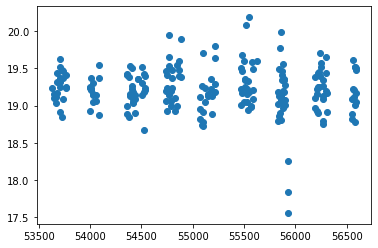

In [710]:
X=np.array(curve.MJD)[np.newaxis].T
y=np.array(curve.Mag)
yerr=np.array(curve.Magerr)
x_fine=np.arange(int(X.min()),int(X.max())+1000)[np.newaxis].T
#X_train=X
#y_train=y
#yerr_train=yerr
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=7*len(X)//10, replace=False)
X_train, y_train = X[training_indices], y[training_indices]
yerr_train=yerr[training_indices]
plt.scatter(X_train,y_train)

In [711]:
%%time
kernel=k.RationalQuadratic(length_scale_bounds=(1e-7,1e5))+k.ConstantKernel()+k.RBF(length_scale=1000)
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha= yerr_train**2, n_restarts_optimizer=20)

gaussian_process.fit(X_train, y_train)
mean_prediction, std_prediction = gaussian_process.predict(x_fine, return_std=True)
gaussian_process.kernel_


CPU times: user 25 s, sys: 2.08 s, total: 27 s
Wall time: 7.74 s


/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


RationalQuadratic(alpha=0.00213, length_scale=0.00127) + 19.1**2 + RBF(length_scale=1e+05)

In [723]:
if (np.percentile(y,99)-y.mean())/y.std()>-(np.percentile(y,1)-y.mean())/y.std():
    trig=X[np.argmax(y)][0]
else:
    trig=X[np.argmin(y)][0]

In [724]:
X.max()-trig,X.min()-trig

(665.1209839581934, -2298.7924687270934)

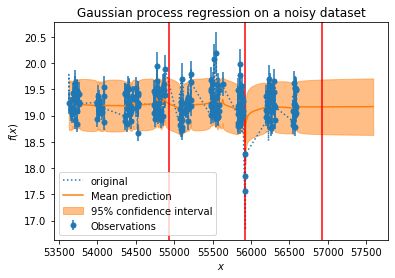

In [725]:
plt.plot(X, y, label=r"original", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train,
    yerr_train,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(x_fine, mean_prediction, label="Mean prediction")
plt.fill_between(
    x_fine.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")
plt.axvline(trig,c='r')
plt.axvline(trig+1000,c='r')
plt.axvline(trig-1000,c='r')

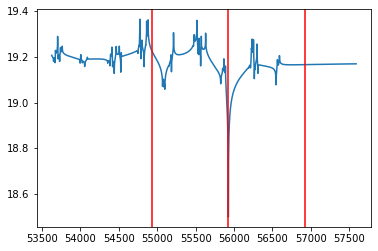

In [726]:
plt.plot(x_fine,mean_prediction)
plt.axvline(trig,c='r')
plt.axvline(trig+1000,c='r')
plt.axvline(trig-1000,c='r')

In [739]:
print(datetime.now().strftime("%H:%M:%S"))
trigs=[]
means=[]
stds=[]
mins=[]
maxs=[]
nams=[]
for name in names:
    filt=df.ID==name
    curve=(df[filt]).sort_values(by=['MJD'])
    if len(curve)>10:
        nams+=[name]
        label=dfla.Classification[dfla.TransientID==float(name[6:])]
        X=np.array(curve.MJD)[np.newaxis].T
        y=np.array(curve.Mag)
        if (np.percentile(y,95)-y.mean())/y.std()>-(np.percentile(y,5)-y.mean())/y.std():
            trig=X[np.argmax(y)][0]
        else:
            trig=X[np.argmin(y)][0]
        X_train=np.array(curve.MJD)[np.newaxis].T
        y_train=np.array(curve.Mag)
        yerr_train=np.array(curve.Magerr)
        x_fine=np.arange(int(trig)-1000,int(trig)+1000)[np.newaxis].T
        kernel=k.RationalQuadratic(length_scale_bounds=(1e-7,1e5))+k.ConstantKernel()+k.RBF(length_scale=1000)
        gaussian_process = GaussianProcessRegressor(
        kernel=kernel, alpha= yerr_train**2, n_restarts_optimizer=20)
        gaussian_process.fit(X_train, y_train)
        mean_prediction, std_prediction = gaussian_process.predict(x_fine, return_std=True)
        trigs+=[trig]
        means+=[mean_prediction]
        stds+=[std_prediction]
        mins+=[X.min()]
        maxs+=[X.max()]
print(datetime.now().strftime("%H:%M:%S"))

08:07:53


/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnin

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnin

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:1893: RuntimeWarning: invalid value encountered in reciprocal
  K = base ** -self.alpha
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning:

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calli

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnin

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnin

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnin

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calli

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warni

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnin

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproce

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warn

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and call

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    h

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/germanchaparro/miniconda2/envs/pmenv/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__length_scale is close to the specified lower bound 1e-07. Decreasing the bound and calling fit again may find a better value.
  warnin

10:09:30


Text(0.5, 1.0, 'Var')

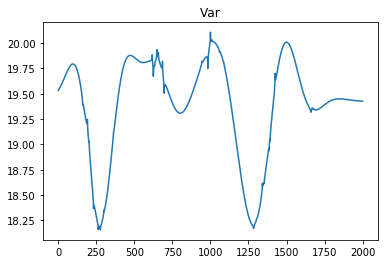

In [765]:
plt.plot(means[104])
plt.title(dfla.Classification[dfla.TransientID==float(nams[104][6:])].iloc[0])

In [762]:
dfla.Classification[dfla.TransientID==float(nams[102][6:])].iloc[0]

'SN'

55926.221370335705